In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import time
import networkx as nx

Using backend: pytorch


Running on the GPU


In [2]:
class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [3]:
class QValue(nn.Module):
    def __init__(
        self,
        input_size_state,
        input_size_action,
        hidden_sizes
    ):
        super(QValue, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size_action + input_size_state
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], 1))
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        
        for layer in self.layers:
            x = layer(x)
            
        return x
    
class Policy(nn.Module):
    def __init__(
        self,
        input_size_state,
        hidden_sizes,
        output_size
    ):
        super(Policy, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size_state
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], output_size))
        self.layers.append(nn.Tanh())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [4]:
class DDPGagent:
    def __init__(self, env, q_hidden_sizes=[32, 64, 128, 64, 32], p_hidden_sizes=[32, 64, 128, 64, 32], actor_learning_rate=1e-3, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=int(1e6)):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks

        self.actor = Policy(self.num_states, p_hidden_sizes, self.num_actions).to(device)
        self.actor_target = Policy(self.num_states, p_hidden_sizes, self.num_actions).to(device)
        self.critic = QValue(self.num_states, self.num_actions, q_hidden_sizes).to(device)
        self.critic_target = QValue(self.num_states, self.num_actions, q_hidden_sizes).to(device)
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
        lmbda = lambda epoch: 0.8
        self.actor_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(self.actor_optimizer, lr_lambda=lmbda)
        self.critic_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(self.actor_optimizer, lr_lambda=lmbda)

    def get_action(self, state):
        state = torch.from_numpy(state).float().to(device)
        action = self.actor.forward(state)
        return action.cpu().detach().numpy()
    
    def get_latest_lr(self):
        return self.critic_lr_scheduler.get_last_lr()
    
    def update_lr(self):
        self.critic_lr_scheduler.step()
        self.actor_lr_scheduler.step()
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.FloatTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()
        
        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
    def save_agent_networks(self, prefix):
        torch.save(self.actor, prefix + '-actor.pt')
        torch.save(self.critic, prefix + '-critic.pt')
        
    def load_agent_networks(self, prefix):
        self.actor = torch.load(prefix + '-actor.pt').to(device)
        self.critic = torch.load(prefix + '-critic.pt').to(device)
        self.actor_target = self.actor
        self.critic_target = self.critic
        

In [6]:
env = HalfCheetahGraphEnv(None)
allAgents = dict()
allRewards = dict()
allAvgRewards = dict()
for idx in [7, 8, 9]:
    env.set_morphology(idx)
    state = env.reset()

    agent = DDPGagent(env, gamma=0.99)
    batch_size = 128
    rewards = []
    avg_rewards = []
    learningRates = []
    episodeLengths = []
    for episode in range(800):
        t0 = time.time()
        state = env.reset()
        episode_reward = 0
        step = 0
        done = False

        for i in range(500):
            action = agent.get_action(state)
            action = np.clip(action + np.random.normal(0, 0.1, env.action_space.shape), -1, 1)
            new_state, reward, done, _ = env.step(action)
            agent.memory.push(state, action, reward, new_state, done)

            if len(agent.memory) > batch_size:
                agent.update(batch_size)


            state = new_state
            episode_reward += reward
            step += 1

            if done:
                break

        if episode % 50 == 0:
            agent.update_lr()

        print("episode {} in {}s: reward for episode: {} || average reward: {} || episode length: {}\n".format(episode, np.round(time.time() - t0, decimals=1), np.round(episode_reward, decimals=2), 
                                                                                                                  np.round(np.mean(rewards[-25:]), decimals=2), step))

        episodeLengths.append(step)
        rewards.append(episode_reward)
        avg_rewards.append(np.mean(rewards[-25:]))
        learningRates.append(agent.get_latest_lr())
    
    allAgents[idx] = agent
    allRewards[idx] = rewards
    allAvgRewards[idx] = avg_rewards



/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************


/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 0 in 4.9s: reward for episode: -21.33 || average reward: nan || episode length: 500

episode 1 in 5.6s: reward for episode: 1.46 || average reward: -21.33 || episode length: 500

episode 2 in 4.9s: reward for episode: -1.56 || average reward: -9.94 || episode length: 500

episode 3 in 5.2s: reward for episode: 3.1 || average reward: -7.14 || episode length: 500

episode 4 in 5.1s: reward for episode: 6.63 || average reward: -4.58 || episode length: 500

episode 5 in 5.0s: reward for episode: -2.27 || average reward: -2.34 || episode length: 500

episode 6 in 5.1s: reward for episode: 6.1 || average reward: -2.33 || episode length: 500

episode 7 in 4.9s: reward for episode: 4.04 || average reward: -1.12 || episode length: 500

episode 8 in 5.0s: reward for episode: 2.63 || average reward: -0.48 || episode length: 500

episode 9 in 4.8s: reward for episode: -48.04 || average reward: -0.13 || episode length: 500

episode 10 in 4.8s: reward for episode: 3.36 || average reward: -4.

episode 87 in 5.0s: reward for episode: 1.04 || average reward: 3.84 || episode length: 500

episode 88 in 5.0s: reward for episode: -5.08 || average reward: 3.78 || episode length: 500

episode 89 in 5.0s: reward for episode: -8.97 || average reward: 3.64 || episode length: 500

episode 90 in 5.0s: reward for episode: 6.05 || average reward: 3.13 || episode length: 500

episode 91 in 5.0s: reward for episode: 6.72 || average reward: 3.28 || episode length: 500

episode 92 in 5.0s: reward for episode: 3.74 || average reward: 3.4 || episode length: 500

episode 93 in 5.0s: reward for episode: 9.15 || average reward: 3.74 || episode length: 500

episode 94 in 5.0s: reward for episode: -11.28 || average reward: 4.87 || episode length: 500

episode 95 in 5.1s: reward for episode: -16.19 || average reward: 4.04 || episode length: 500

episode 96 in 5.0s: reward for episode: 4.86 || average reward: 3.79 || episode length: 500

episode 97 in 5.1s: reward for episode: 5.45 || average reward: 3

episode 175 in 5.1s: reward for episode: -4.55 || average reward: 2.87 || episode length: 500

episode 176 in 5.1s: reward for episode: 5.35 || average reward: 2.59 || episode length: 500

episode 177 in 5.1s: reward for episode: 6.68 || average reward: 2.5 || episode length: 500

episode 178 in 5.1s: reward for episode: 7.89 || average reward: 3.52 || episode length: 500

episode 179 in 5.1s: reward for episode: 7.73 || average reward: 3.72 || episode length: 500

episode 180 in 5.1s: reward for episode: -1.62 || average reward: 4.2 || episode length: 500

episode 181 in 5.1s: reward for episode: 4.65 || average reward: 4.35 || episode length: 500

episode 182 in 5.1s: reward for episode: -18.66 || average reward: 3.96 || episode length: 500

episode 183 in 5.1s: reward for episode: 16.26 || average reward: 2.72 || episode length: 500

episode 184 in 5.2s: reward for episode: -6.99 || average reward: 3.29 || episode length: 500

episode 185 in 5.1s: reward for episode: -9.82 || averag

episode 262 in 5.2s: reward for episode: 1.96 || average reward: -1.24 || episode length: 500

episode 263 in 5.2s: reward for episode: 1.57 || average reward: -1.47 || episode length: 500

episode 264 in 5.2s: reward for episode: 1.73 || average reward: -1.65 || episode length: 500

episode 265 in 5.3s: reward for episode: 1.97 || average reward: -1.54 || episode length: 500

episode 266 in 5.3s: reward for episode: 2.05 || average reward: -1.98 || episode length: 500

episode 267 in 5.3s: reward for episode: -96.25 || average reward: -1.7 || episode length: 500

episode 268 in 5.3s: reward for episode: -27.73 || average reward: -5.24 || episode length: 500

episode 269 in 5.3s: reward for episode: 2.08 || average reward: -5.01 || episode length: 500

episode 270 in 5.3s: reward for episode: 2.3 || average reward: -5.12 || episode length: 500

episode 271 in 5.4s: reward for episode: 2.0 || average reward: -4.8 || episode length: 500

episode 272 in 5.3s: reward for episode: 4.33 || a

episode 350 in 5.5s: reward for episode: 6.77 || average reward: 4.07 || episode length: 500

episode 351 in 5.5s: reward for episode: -1.78 || average reward: 4.28 || episode length: 500

episode 352 in 5.5s: reward for episode: 4.89 || average reward: 4.12 || episode length: 500

episode 353 in 5.5s: reward for episode: -2.37 || average reward: 4.26 || episode length: 500

episode 354 in 5.6s: reward for episode: 3.32 || average reward: 4.08 || episode length: 500

episode 355 in 5.6s: reward for episode: 5.58 || average reward: 4.05 || episode length: 500

episode 356 in 5.5s: reward for episode: 17.11 || average reward: 4.15 || episode length: 500

episode 357 in 5.4s: reward for episode: 14.19 || average reward: 4.6 || episode length: 500

episode 358 in 5.5s: reward for episode: -34.1 || average reward: 4.8 || episode length: 500

episode 359 in 5.7s: reward for episode: 0.67 || average reward: 3.18 || episode length: 500

episode 360 in 5.6s: reward for episode: 20.16 || average

episode 437 in 5.8s: reward for episode: 6.19 || average reward: 6.64 || episode length: 500

episode 438 in 5.7s: reward for episode: 15.62 || average reward: 5.93 || episode length: 500

episode 439 in 5.8s: reward for episode: 8.35 || average reward: 5.76 || episode length: 500

episode 440 in 5.8s: reward for episode: 6.26 || average reward: 5.3 || episode length: 500

episode 441 in 5.8s: reward for episode: 3.36 || average reward: 5.69 || episode length: 500

episode 442 in 5.8s: reward for episode: 10.21 || average reward: 5.62 || episode length: 500

episode 443 in 5.8s: reward for episode: 6.12 || average reward: 5.49 || episode length: 500

episode 444 in 5.8s: reward for episode: 11.48 || average reward: 4.68 || episode length: 500

episode 445 in 5.8s: reward for episode: 7.73 || average reward: 4.88 || episode length: 500

episode 446 in 5.8s: reward for episode: 5.48 || average reward: 4.41 || episode length: 500

episode 447 in 5.8s: reward for episode: 5.05 || average r

episode 525 in 6.1s: reward for episode: 6.32 || average reward: 5.47 || episode length: 500

episode 526 in 6.1s: reward for episode: 4.7 || average reward: 5.56 || episode length: 500

episode 527 in 6.1s: reward for episode: 5.26 || average reward: 5.49 || episode length: 500

episode 528 in 6.1s: reward for episode: 4.89 || average reward: 5.45 || episode length: 500

episode 529 in 6.1s: reward for episode: 4.53 || average reward: 5.41 || episode length: 500

episode 530 in 6.1s: reward for episode: 4.62 || average reward: 5.33 || episode length: 500

episode 531 in 6.2s: reward for episode: 1.49 || average reward: 5.29 || episode length: 500

episode 532 in 6.1s: reward for episode: 3.13 || average reward: 5.08 || episode length: 500

episode 533 in 6.1s: reward for episode: 3.22 || average reward: 5.01 || episode length: 500

episode 534 in 6.1s: reward for episode: 3.15 || average reward: 4.94 || episode length: 500

episode 535 in 6.1s: reward for episode: 1.91 || average rewa

episode 613 in 6.4s: reward for episode: 2.66 || average reward: -3.85 || episode length: 500

episode 614 in 6.4s: reward for episode: 1.45 || average reward: -3.89 || episode length: 500

episode 615 in 6.3s: reward for episode: 1.92 || average reward: -3.94 || episode length: 500

episode 616 in 6.3s: reward for episode: 1.72 || average reward: -4.11 || episode length: 500

episode 617 in 6.3s: reward for episode: 6.82 || average reward: -4.3 || episode length: 500

episode 618 in 6.4s: reward for episode: 6.64 || average reward: -4.21 || episode length: 500

episode 619 in 6.3s: reward for episode: 9.46 || average reward: -4.11 || episode length: 500

episode 620 in 6.3s: reward for episode: 8.21 || average reward: -3.86 || episode length: 500

episode 621 in 6.3s: reward for episode: 9.18 || average reward: -3.71 || episode length: 500

episode 622 in 6.3s: reward for episode: -10.0 || average reward: -3.38 || episode length: 500

episode 623 in 6.3s: reward for episode: 8.87 || a

episode 700 in 6.5s: reward for episode: 4.73 || average reward: 4.85 || episode length: 500

episode 701 in 6.7s: reward for episode: 4.9 || average reward: 4.67 || episode length: 500

episode 702 in 6.5s: reward for episode: 6.5 || average reward: 4.59 || episode length: 500

episode 703 in 6.6s: reward for episode: 4.18 || average reward: 4.5 || episode length: 500

episode 704 in 6.6s: reward for episode: 10.76 || average reward: 4.36 || episode length: 500

episode 705 in 6.6s: reward for episode: 2.97 || average reward: 4.64 || episode length: 500

episode 706 in 6.5s: reward for episode: 6.86 || average reward: 4.44 || episode length: 500

episode 707 in 6.6s: reward for episode: 3.92 || average reward: 4.56 || episode length: 500

episode 708 in 6.6s: reward for episode: -3.49 || average reward: 4.57 || episode length: 500

episode 709 in 6.6s: reward for episode: 6.55 || average reward: 4.37 || episode length: 500

episode 710 in 6.6s: reward for episode: 4.92 || average rewa

episode 788 in 9.0s: reward for episode: 6.76 || average reward: 2.09 || episode length: 500

episode 789 in 8.9s: reward for episode: 5.54 || average reward: 2.31 || episode length: 500

episode 790 in 9.0s: reward for episode: 6.55 || average reward: 2.39 || episode length: 500

episode 791 in 8.9s: reward for episode: -4.1 || average reward: 2.6 || episode length: 500

episode 792 in 8.9s: reward for episode: 5.66 || average reward: 2.19 || episode length: 500

episode 793 in 8.8s: reward for episode: -4.41 || average reward: 2.35 || episode length: 500

episode 794 in 8.9s: reward for episode: -6.08 || average reward: 2.05 || episode length: 500

episode 795 in 9.0s: reward for episode: 7.31 || average reward: 2.06 || episode length: 500

episode 796 in 9.1s: reward for episode: 7.43 || average reward: 2.19 || episode length: 500

episode 797 in 9.0s: reward for episode: 5.19 || average reward: 2.43 || episode length: 500

episode 798 in 9.0s: reward for episode: 6.99 || average re

NoneType: None


episode 0 in 5.2s: reward for episode: -6.12 || average reward: nan || episode length: 500

episode 1 in 6.6s: reward for episode: 4.52 || average reward: -6.12 || episode length: 500

episode 2 in 6.6s: reward for episode: 8.85 || average reward: -0.8 || episode length: 500

episode 3 in 6.5s: reward for episode: -23.48 || average reward: 2.42 || episode length: 500

episode 4 in 6.7s: reward for episode: -10.73 || average reward: -4.06 || episode length: 500

episode 5 in 6.8s: reward for episode: 2.05 || average reward: -5.39 || episode length: 500

episode 6 in 6.8s: reward for episode: -6.49 || average reward: -4.15 || episode length: 500

episode 7 in 6.8s: reward for episode: -1.74 || average reward: -4.49 || episode length: 500

episode 8 in 6.8s: reward for episode: 3.71 || average reward: -4.14 || episode length: 500

episode 9 in 6.8s: reward for episode: -33.76 || average reward: -3.27 || episode length: 500

episode 10 in 7.0s: reward for episode: -42.2 || average reward: 

episode 87 in 6.3s: reward for episode: 2.32 || average reward: 0.54 || episode length: 500

episode 88 in 5.9s: reward for episode: 5.35 || average reward: 0.44 || episode length: 500

episode 89 in 5.4s: reward for episode: -20.79 || average reward: 0.54 || episode length: 500

episode 90 in 5.6s: reward for episode: 1.89 || average reward: -0.49 || episode length: 500

episode 91 in 5.5s: reward for episode: -9.38 || average reward: -0.41 || episode length: 500

episode 92 in 5.6s: reward for episode: 1.74 || average reward: -0.8 || episode length: 500

episode 93 in 5.5s: reward for episode: 7.59 || average reward: -0.83 || episode length: 500

episode 94 in 5.5s: reward for episode: 7.03 || average reward: 0.73 || episode length: 500

episode 95 in 5.4s: reward for episode: 6.67 || average reward: 1.31 || episode length: 500

episode 96 in 5.4s: reward for episode: 9.55 || average reward: 1.54 || episode length: 500

episode 97 in 5.4s: reward for episode: 6.48 || average reward: 

episode 174 in 5.7s: reward for episode: 4.87 || average reward: -3.21 || episode length: 500

episode 175 in 5.5s: reward for episode: 5.71 || average reward: -3.07 || episode length: 500

episode 176 in 5.5s: reward for episode: 13.67 || average reward: -3.02 || episode length: 500

episode 177 in 5.6s: reward for episode: 8.89 || average reward: -3.07 || episode length: 500

episode 178 in 5.6s: reward for episode: 6.71 || average reward: -2.97 || episode length: 500

episode 179 in 5.1s: reward for episode: 10.44 || average reward: -1.59 || episode length: 500

episode 180 in 6.1s: reward for episode: 4.29 || average reward: -0.89 || episode length: 500

episode 181 in 6.2s: reward for episode: 6.48 || average reward: 0.58 || episode length: 500

episode 182 in 6.0s: reward for episode: 4.59 || average reward: 2.34 || episode length: 500

episode 183 in 6.3s: reward for episode: 5.21 || average reward: 3.71 || episode length: 500

episode 184 in 5.6s: reward for episode: 6.35 || av

KeyboardInterrupt: 

In [13]:
    
allAgents[idx] = agent
allRewards[idx] = rewards
allAvgRewards[idx] = avg_rewards


None
*************************************************************************************************************


/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


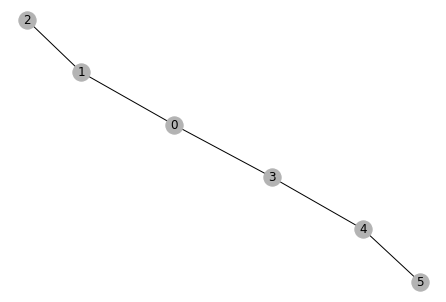

In [30]:
env = HalfCheetahGraphEnv(None)
env.set_morphology(0)
g = env.get_graph()._get_dgl_graph()
nx_G = g.cpu().to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [74]:
a = torch.rand((6, 512, 128))
b = torch.tensor([1, 2, 3, 4, 5, 6])
c = b.repeat(512, 1).T.unsqueeze(-1)

In [76]:
torch.cat((a, c), -1).shape

torch.Size([6, 512, 129])

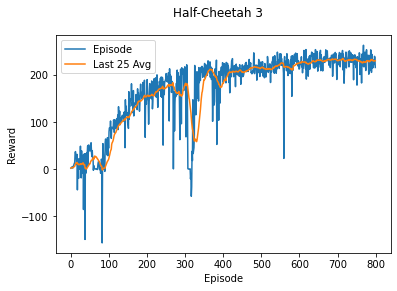

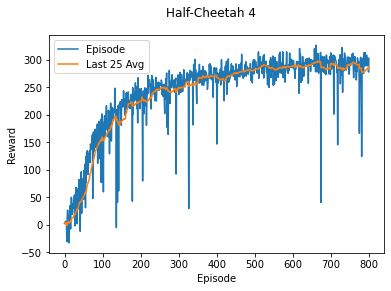

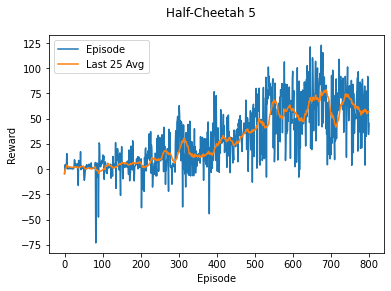

In [20]:
for idx in [3, 4, 5]:
    avg_rewards = allAvgRewards[idx]
    rewards = allRewards[idx]
    
    fig, ax = plt.subplots()
    ax.plot(range(len(rewards)), rewards)
    ax.plot(range(len(avg_rewards)), avg_rewards)
    ax.set(ylabel='Reward')
    ax.legend(["Episode", "Last 25 Avg"])
    plt.xlabel('Episode')
    plt.suptitle('Half-Cheetah {}'.format(idx))
    plt.show()
    fig.savefig('{}-new-halfCheetah-Training.jpg'.format(idx))

In [21]:
for idx in [3, 4, 5]:
    allAgents[idx].save_agent_networks('{}-new-halfCheetah'.format(idx))

In [26]:
for idx in range(7):
    env = HalfCheetahGraphEnv(None)
    env.set_morphology(idx)
    
    agent = DDPGagent(env)
    agent.load_agent_networks('new/{}-halfCheetah'.format(idx))
    
    episodeRewards = []
    states, actions, rewards, next_states, dones = [], [], [], [], []
    collectedSamples = 0
    samplesToPrint = 10000
    while collectedSamples < 1e6:
        state = env.reset()

        step = 0
        episodeReward = 0
        for i in range(500):
            action = agent.get_action(state)
            action = np.clip(action + np.random.normal(0, 0.1, env.action_space.shape), -1, 1)
            next_state, reward, done, _ = env.step(action)
            episodeReward += reward
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

            state = next_state
            step += 1
            collectedSamples += 1
            samplesToPrint -= 1
        
        episodeRewards.append(episodeReward)
        if samplesToPrint <= 0:
            print(collectedSamples)
            print('Average Rewards', np.mean(episodeRewards[-20]))
            samplesToPrint = 10000
        
    np.save("../datasets/{}/actions_array".format(idx), np.array(actions))
    np.save("../datasets/{}/states_array".format(idx), np.array(states))
    np.save("../datasets/{}/next_states_array".format(idx), np.array(next_states))
    np.save("../datasets/{}/rewards_array".format(idx), np.array(rewards))
    np.save("../datasets/{}/dones_array".format(idx), np.array(dones))

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 54.367476613400676
20000
Average Rewards 53.29001068515028
30000
Average Rewards 55.02574653013839
40000
Average Rewards 53.55440477666882
50000
Average Rewards 54.59336251209168
60000
Average Rewards 60.462224450906604
70000
Average Rewards 57.339725545821786
80000
Average Rewards 62.06238784076178
90000
Average Rewards 16.29337205945175
100000
Average Rewards 45.30458490243595
110000
Average Rewards 50.79036350545519
120000
Average Rewards 56.08981776549404
130000
Average Rewards 58.89845518898338
140000
Average Rewards 58.907066646910756
150000
Average Rewards 45.47166838060321
160000
Average Rewards 58.937156559439074
170000
Average Rewards 59.08149786077927
180000
Average Rewards 60.982445999820776
190000
Average Rewards 61.72129520998914
200000
Average Rewards 62.23728140592128
210000
Average Rewards 47.97493568410329
220000
Average Rewards 53.2

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 129.7223676123196
20000
Average Rewards 132.83704725567887
30000
Average Rewards 137.9838981421246
40000
Average Rewards 138.09857256710683
50000
Average Rewards 145.99477572408918
60000
Average Rewards 133.7602704056762
70000
Average Rewards 145.81577058682268
80000
Average Rewards 141.56464350383376
90000
Average Rewards 135.1909686628194
100000
Average Rewards 141.77912927686887
110000
Average Rewards 136.96154260794157
120000
Average Rewards 136.7776123753255
130000
Average Rewards 135.25371740344892
140000
Average Rewards 141.6910353516006
150000
Average Rewards 128.8518693913328
160000
Average Rewards 135.09686783365862
170000
Average Rewards 145.54329437098775
180000
Average Rewards 137.80070048061228
190000
Average Rewards 136.68064635056126
200000
Average Rewards 147.63128560000695
210000
Average Rewards 139.58639702767238
220000
Average Rewa

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 183.5838877451363
20000
Average Rewards 160.632323983186
30000
Average Rewards 181.6083330750455
40000
Average Rewards 148.83059162461018
50000
Average Rewards 168.4554038952176
60000
Average Rewards 180.0498536531373
70000
Average Rewards 122.04833568512142
80000
Average Rewards 148.41741474300076
90000
Average Rewards 162.9256370724333
100000
Average Rewards 174.4840270695079
110000
Average Rewards 147.15985054349656
120000
Average Rewards 158.65966131776727
130000
Average Rewards 136.16687104950196
140000
Average Rewards 180.77859840490325
150000
Average Rewards 136.35063821624664
160000
Average Rewards 173.42000576740918
170000
Average Rewards 45.55917131326052
180000
Average Rewards 145.21937523791274
190000
Average Rewards 149.93491993942885
200000
Average Rewards 178.3665293229192
210000
Average Rewards 165.89582636585166
220000
Average Rewards

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 214.1070195416373
20000
Average Rewards 247.19803624289528
30000
Average Rewards 209.15729908583876
40000
Average Rewards 208.0874793760356
50000
Average Rewards 228.85918713209537
60000
Average Rewards 216.897691011934
70000
Average Rewards 229.75483976540966
80000
Average Rewards 239.2697220477549
90000
Average Rewards 232.45822399342754
100000
Average Rewards 247.87308863489005
110000
Average Rewards 247.4084026255272
120000
Average Rewards 228.00563316350718
130000
Average Rewards 260.6950073341565
140000
Average Rewards 224.8172019801806
150000
Average Rewards 238.69174708650775
160000
Average Rewards 229.66543997090005
170000
Average Rewards 241.74667250173735
180000
Average Rewards 214.91564102496275
190000
Average Rewards 260.603919046291
200000
Average Rewards 244.68018652184475
210000
Average Rewards 250.4615897613259
220000
Average Rewards 

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 287.76840896097127
20000
Average Rewards 307.49243101133465
30000
Average Rewards 299.1766341162598
40000
Average Rewards 291.92227389751775
50000
Average Rewards 266.65719446473986
60000
Average Rewards 281.0041987209106
70000
Average Rewards 287.199118003596
80000
Average Rewards 294.6798324352384
90000
Average Rewards 292.521233575636
100000
Average Rewards 322.3352160183972
110000
Average Rewards 285.0741273598182
120000
Average Rewards 282.22798939299497
130000
Average Rewards 288.1439629882311
140000
Average Rewards 307.9508909434558
150000
Average Rewards 279.1013966735587
160000
Average Rewards 317.30220883332083
170000
Average Rewards 309.91986285605435
180000
Average Rewards 310.66754646669676
190000
Average Rewards 288.3304696496045
200000
Average Rewards 274.9231945587547
210000
Average Rewards 301.35106180406893
220000
Average Rewards 292

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 56.63591007616398
20000
Average Rewards 78.2109498507955
30000
Average Rewards 62.32901500213822
40000
Average Rewards 80.37896277455424
50000
Average Rewards 25.727823703949078
60000
Average Rewards 86.75475025376676
70000
Average Rewards 40.632086557539246
80000
Average Rewards 34.19325052826232
90000
Average Rewards 48.50329294198036
100000
Average Rewards 81.53734548238147
110000
Average Rewards 48.21077253382053
120000
Average Rewards 73.05978672803856
130000
Average Rewards 106.61664686666008
140000
Average Rewards 75.51553799262865
150000
Average Rewards 65.79059607592367
160000
Average Rewards 34.23067135818249
170000
Average Rewards 72.49418022968943
180000
Average Rewards 41.809893419220806
190000
Average Rewards 66.6919194318182
200000
Average Rewards 70.84508228972464
210000
Average Rewards 22.29259393965106
220000
Average Rewards 58.23876

NoneType: None


None
*************************************************************************************************************
10000
Average Rewards 69.35398309545164
20000
Average Rewards 118.33724551023136
30000
Average Rewards 110.81198140026089
40000
Average Rewards 99.41508677401299
50000
Average Rewards 108.06189284942904
60000
Average Rewards 94.61070716493998
70000
Average Rewards 111.05058023653149
80000
Average Rewards 109.518391745439
90000
Average Rewards 102.78368955796935
100000
Average Rewards 122.41257443493616
110000
Average Rewards 102.66898091141036
120000
Average Rewards 105.54800831296949
130000
Average Rewards 128.19298369613654
140000
Average Rewards 74.66307675487745
150000
Average Rewards 105.94601537873469
160000
Average Rewards 73.73576747431284
170000
Average Rewards 105.07292951009865
180000
Average Rewards 107.61588614055971
190000
Average Rewards 98.95198855794324
200000
Average Rewards 117.56313509485238
210000
Average Rewards 117.0404927149402
220000
Average Reward

In [8]:
print(m.december)

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/morphsim/xml_files/december


In [ ]:
env.close()

In [ ]:
actions_array = np.array(actions)
states_array = np.array(states)
next_states_array = np.array(next_states)
rewards_array = np.array(rewards)
dones_array = np.array(dones)

In [ ]:
np.save("doubleInvertedPendulumDataset/actions_array", actions_array)
np.save("doubleInvertedPendulumDataset/states_array", states_array)
np.save("doubleInvertedPendulumDataset/next_states_array", next_states_array)
np.save("doubleInvertedPendulumDataset/rewards_array", rewards_array)
np.save("doubleInvertedPendulumDataset/dones_array", dones_array)

In [ ]:
np.std(actions_array)